# Equal-frequency discretization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
# let's separate the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((14448, 8), (6192, 8))

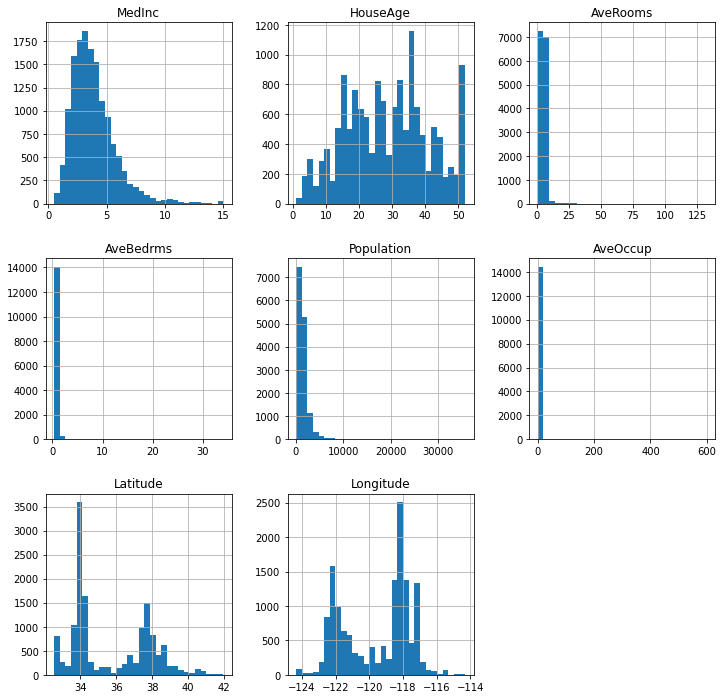

In [4]:
# Plot histograms to inspect variable distributions

X_train.hist(bins=30, figsize=(12, 12))
plt.show()

## Equal-frequency discretization with pandas

The interval limits are the quantile limits. We can find those out with pandas qcut.

In [5]:
# make a copy of the data

train_t = X_train.copy()
test_t = X_test.copy()

In [6]:
# Using pandas qcut (quantile cut) let's cut the variable
# in 8 intervals with similar number of observations.

# Note, we define the limits using the train set.

# retbins = True to return the limits of the intervals
# (so we can then use them to cut the test set)

train_t["House_disc"], interval_limits = pd.qcut(
    x=X_train["HouseAge"],
    q=8,
    labels=None,
    retbins=True,
)

In [7]:
# let's visualize the interval edges

interval_limits

array([ 1., 14., 18., 24., 29., 34., 37., 44., 52.])

In [8]:
# let's have a look at the result: compare original
# and discretized variable

print(train_t[["HouseAge", "House_disc"]].head(5))

      HouseAge    House_disc
1989      52.0  (44.0, 52.0]
256       43.0  (37.0, 44.0]
7887      17.0  (14.0, 18.0]
4581      17.0  (14.0, 18.0]
1993      50.0  (44.0, 52.0]


In [9]:
# and now let's discretise the variable in the test set.

# note how we now use pandas cut() instead of qcut() and
# pass the intervals we determined using the train set:

test_t["House_disc"] = pd.cut(
    x=X_test["HouseAge"], bins=interval_limits, include_lowest=True)

test_t.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,House_disc
14740,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05,"(18.0, 24.0]"
10101,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97,"(29.0, 34.0]"
20566,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84,"(24.0, 29.0]"
2670,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60,"(34.0, 37.0]"
15709,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43,"(24.0, 29.0]"


In [10]:
plt.rcParams["figure.dpi"] = 450

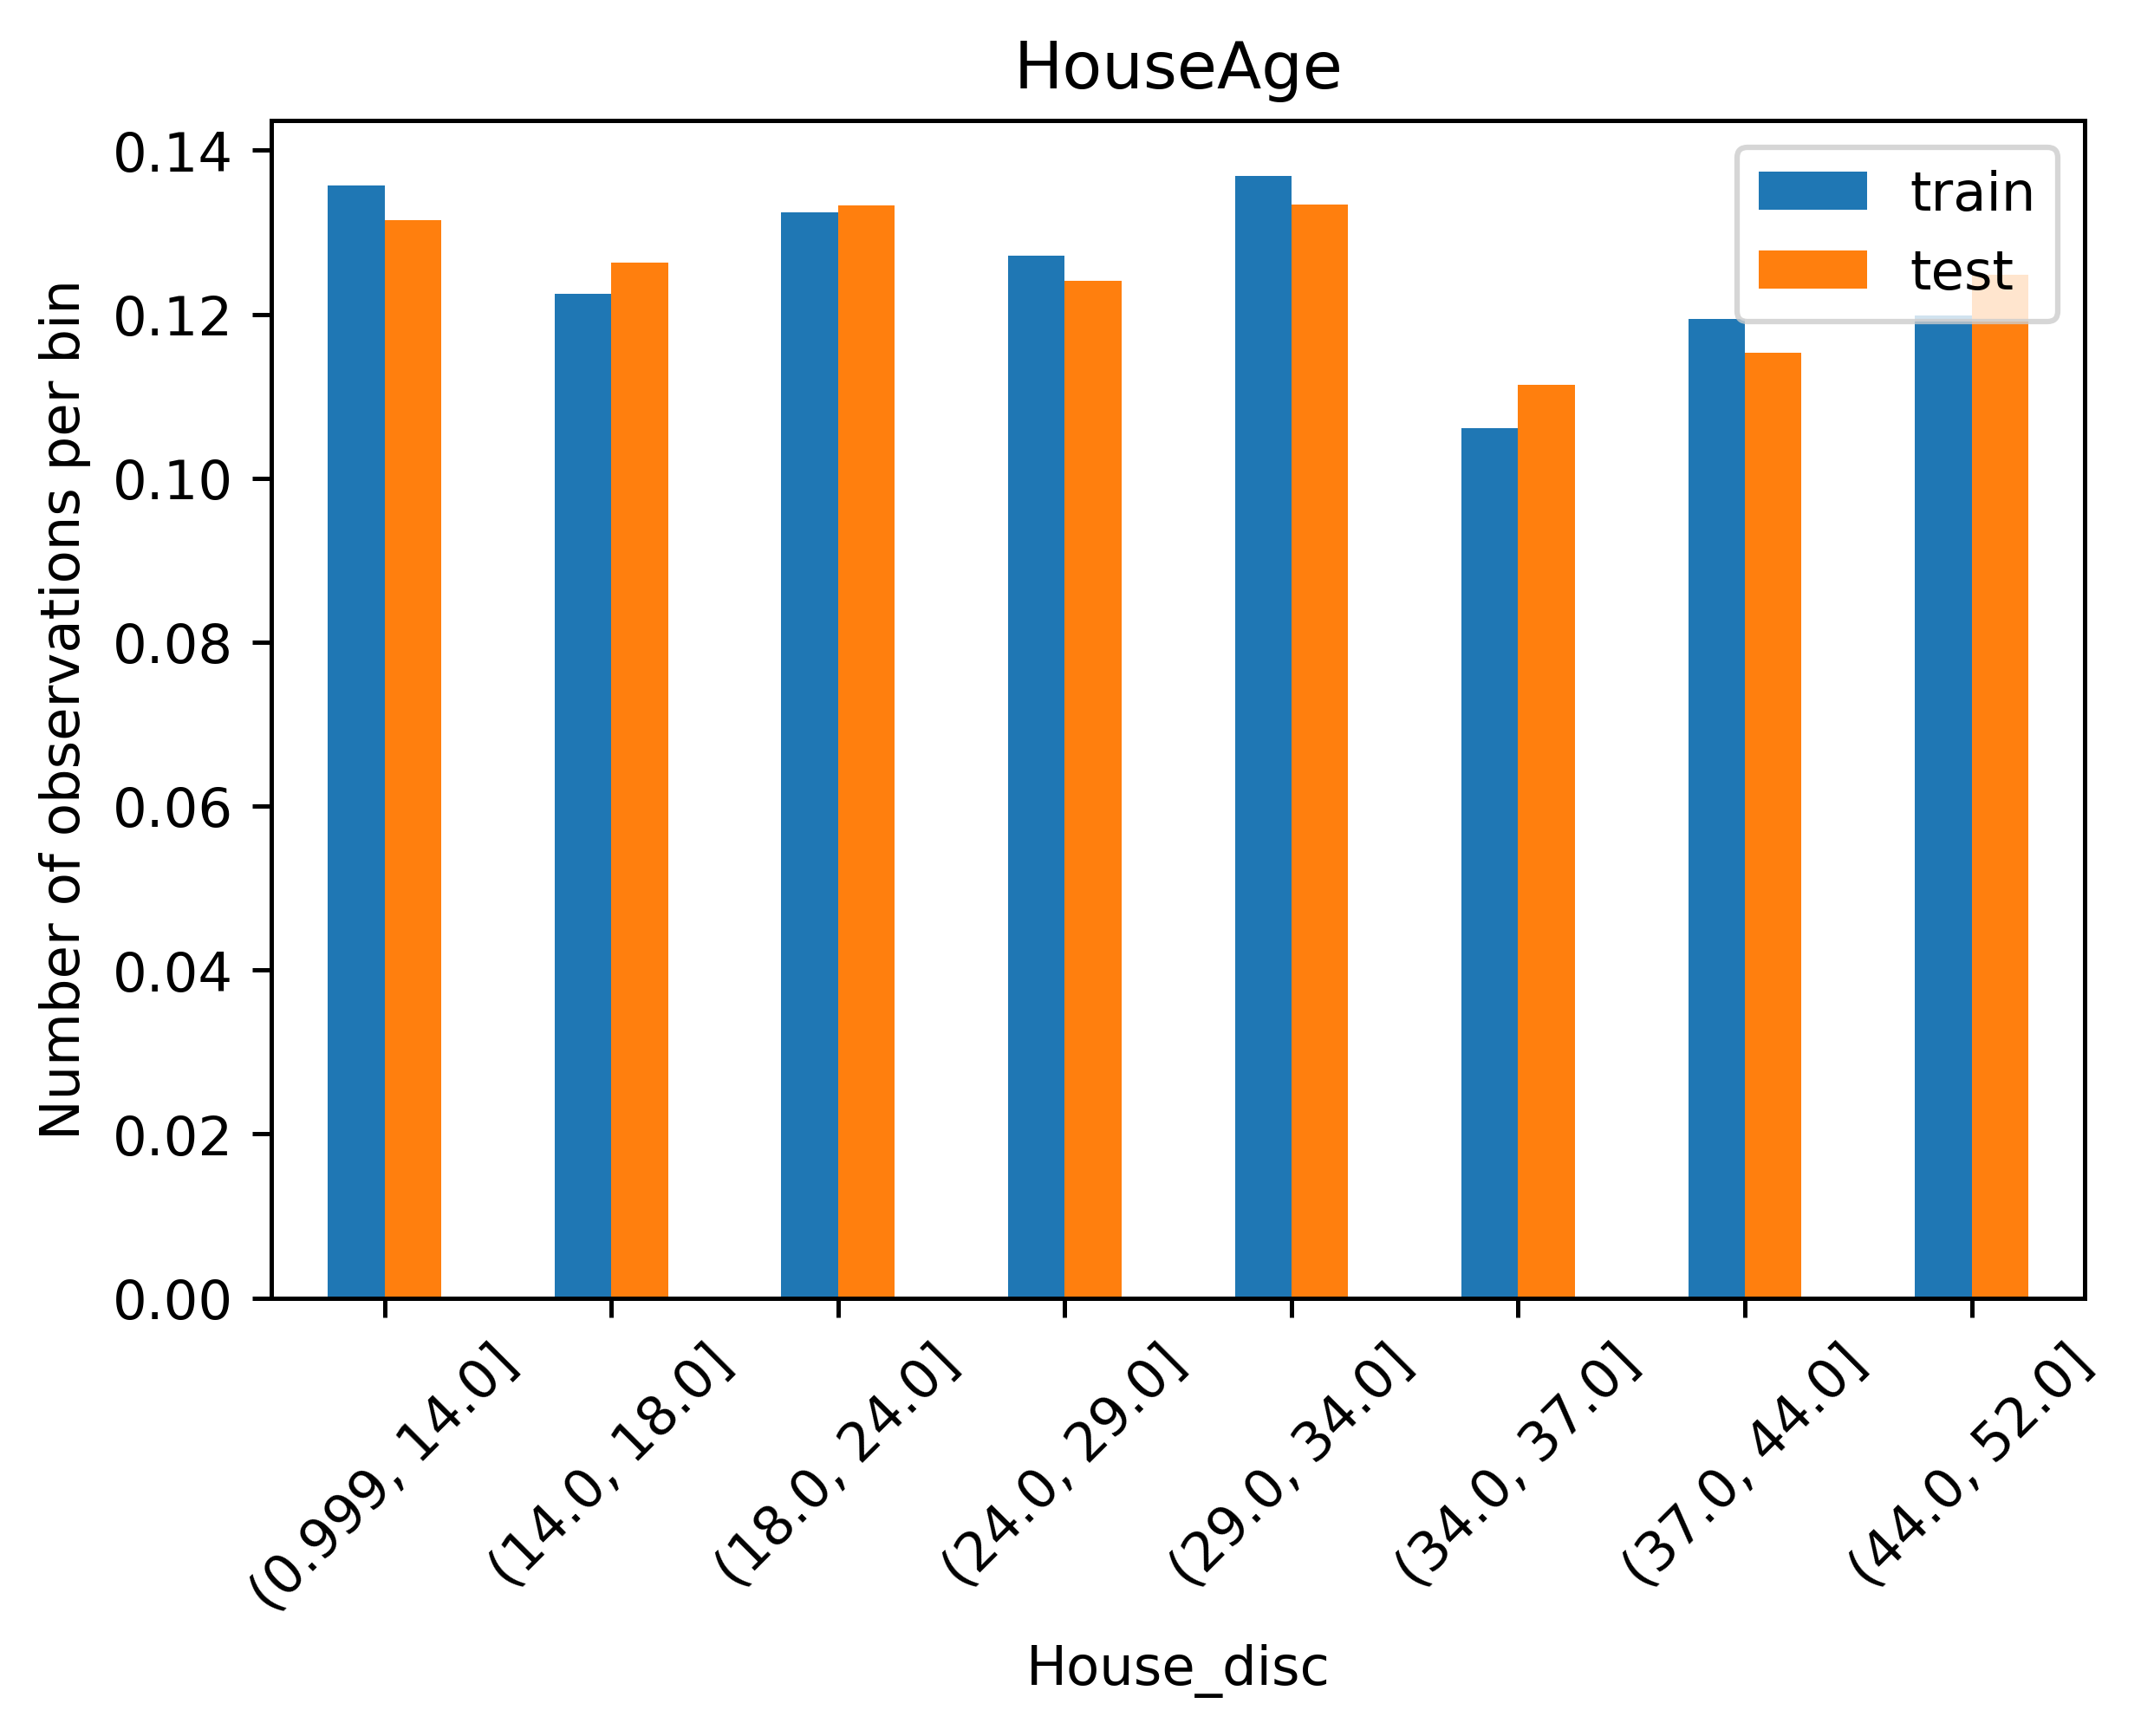

In [11]:
# determine proportion of observations per bin
t1 = train_t["House_disc"].value_counts(normalize=True)
t2 = test_t["House_disc"].value_counts(normalize=True)

# concatenate proportions
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ["train", "test"]
tmp.sort_index(inplace=True)

# plot
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel("Number of observations per bin")
plt.title("HouseAge")
plt.show()

## Equal-frequency discretization with Feature-engine

In [12]:
from feature_engine.discretisation import EqualFrequencyDiscretiser

In [13]:
variables = ["MedInc", "HouseAge", "AveRooms"]

In [14]:
# With feature engine we can discretize subsets of variables
# within the datasets

disc = EqualFrequencyDiscretiser(
    q=8, variables=variables, return_boundaries=True)

disc.fit(X_train)

EqualFrequencyDiscretiser(q=8, return_boundaries=True,
                          variables=['MedInc', 'HouseAge', 'AveRooms'])

In [15]:
# in the binner dict, we can see the limits of the intervals
# for each variable

disc.binner_dict_

{'MedInc': [-inf,
  2.034575,
  2.5705999999999998,
  3.0544875,
  3.5391,
  4.0625,
  4.7361,
  5.82005,
  inf],
 'HouseAge': [-inf, 14.0, 18.0, 24.0, 29.0, 34.0, 37.0, 44.0, inf],
 'AveRooms': [-inf,
  3.9327875134642474,
  4.452248826108891,
  4.863974466763416,
  5.2293176328502415,
  5.59931032069662,
  6.0476190476190474,
  6.716898489638216,
  inf]}

In [16]:
# transform train and test sets

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

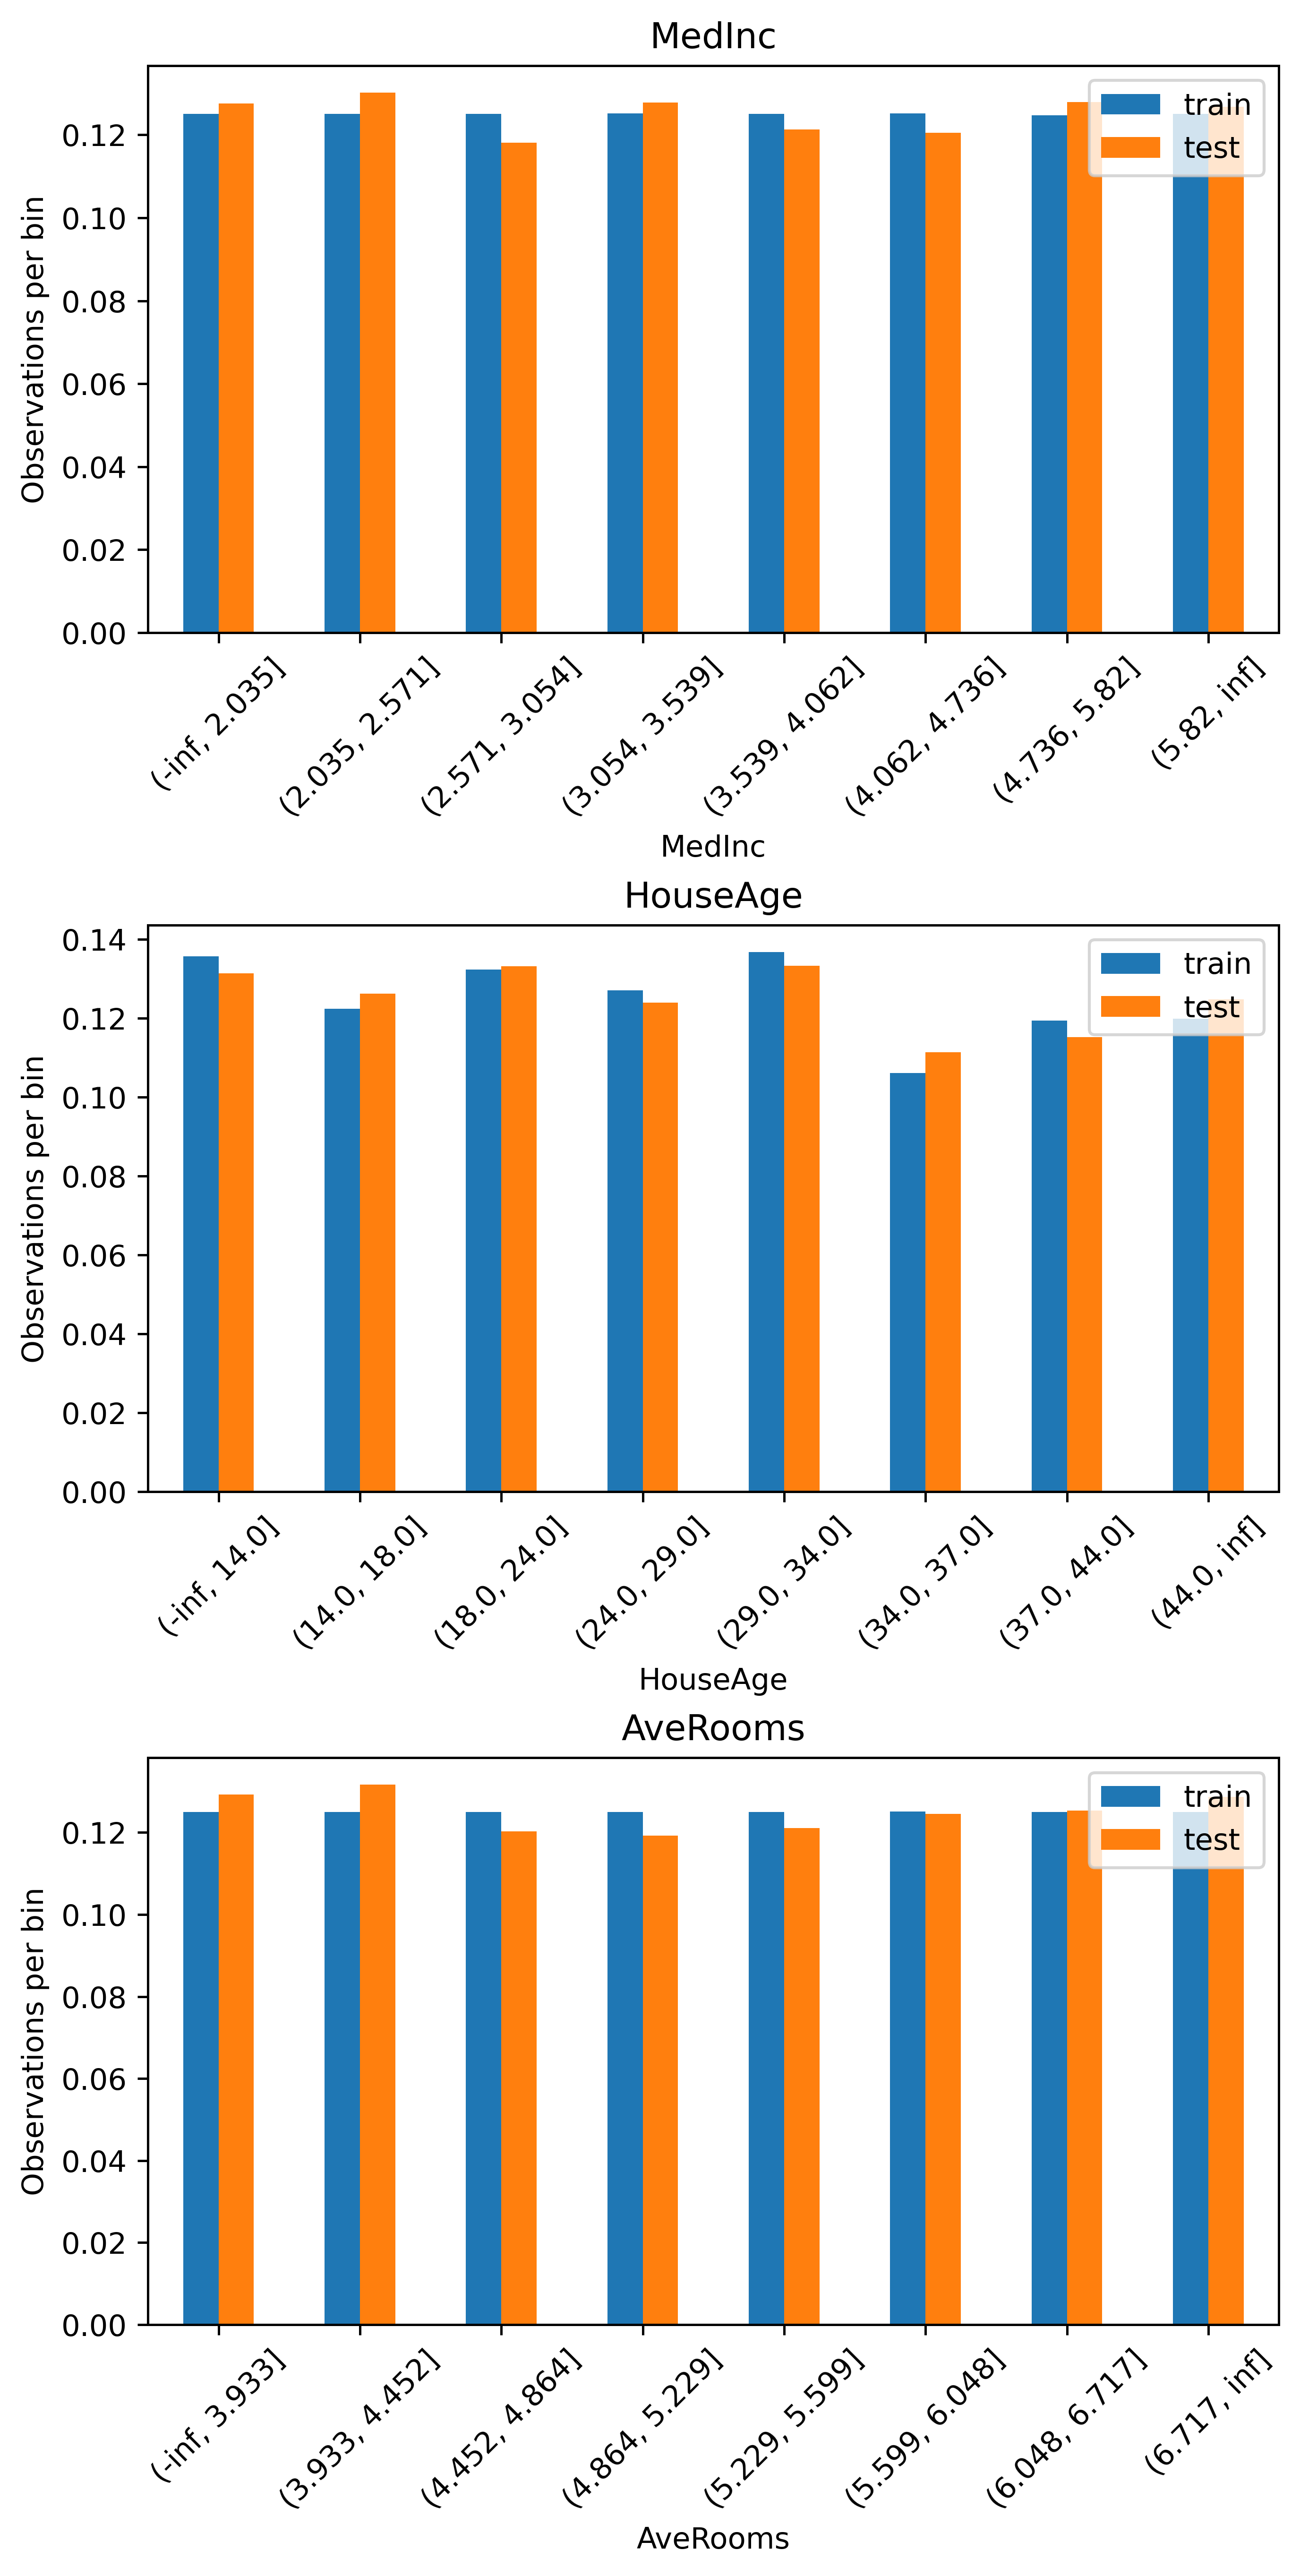

In [17]:
# Let's make bar plots with the number of
# observations per bin for the 3 discretized
# variables:

plt.figure(figsize=(6, 12), constrained_layout=True)

for i in range(3):

    # location of plot in figure
    ax = plt.subplot(3, 1, i + 1)

    # the variable to plot
    var = variables[i]

    # determine proportion of observations per bin
    t1 = train_t[var].value_counts(normalize=True)
    t2 = test_t[var].value_counts(normalize=True)

    # concatenate proportions
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ["train", "test"]

    # sort the intervals
    tmp.sort_index(inplace=True)

    # make plot
    tmp.plot.bar(ax=ax)
    plt.xticks(rotation=45)
    plt.ylabel("Observations per bin")

    # add variable name as title
    ax.set_title(var)

plt.show()

## Equal-frequency discretization with Scikit-Learn

In [18]:
from sklearn.preprocessing import KBinsDiscretizer

In [19]:
# let's set up a discretizer based on quantiles to sort values in 10 bins

disc = KBinsDiscretizer(n_bins=8, encode="ordinal", strategy="quantile")

# fit the discretizer so that it learns the interval edges
disc.fit(X_train[variables])

KBinsDiscretizer(encode='ordinal', n_bins=8)

In [20]:
# the interval edges are stored in a transformer attribute:

disc.bin_edges_

array([array([ 0.4999   ,  2.034575 ,  2.5706   ,  3.0544875,  3.5391   ,
               4.0625   ,  4.7361   ,  5.82005  , 15.0001   ])           ,
       array([ 1., 14., 18., 24., 29., 34., 37., 44., 52.]),
       array([  0.84615385,   3.93278751,   4.45224883,   4.86397447,
                5.22931763,   5.59931032,   6.04761905,   6.71689849,
              132.53333333])                                         ],
      dtype=object)

In [21]:
# Let's make a copy of the original datasets

train_t = X_train.copy()
test_t = X_test.copy()

In [22]:
# let's transform the variables in train and test sets.

# Remember Scikit-learn returns a NumPy arrays by default.
# Here we assigned the array to the variables in our dataframe
# directly.

train_t[variables] = disc.transform(X_train[variables])
test_t[variables] = disc.transform(X_test[variables])

train_t.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
1989,0.0,7.0,0.0,0.700000,193.0,4.825000,36.73,-119.79
256,1.0,6.0,0.0,1.184116,836.0,3.018051,37.77,-122.21
7887,7.0,1.0,6.0,1.087912,1387.0,3.810440,33.87,-118.04
4581,0.0,1.0,0.0,1.196000,3051.0,3.051000,34.06,-118.28
1993,1.0,7.0,2.0,1.161677,606.0,3.628743,36.73,-119.81


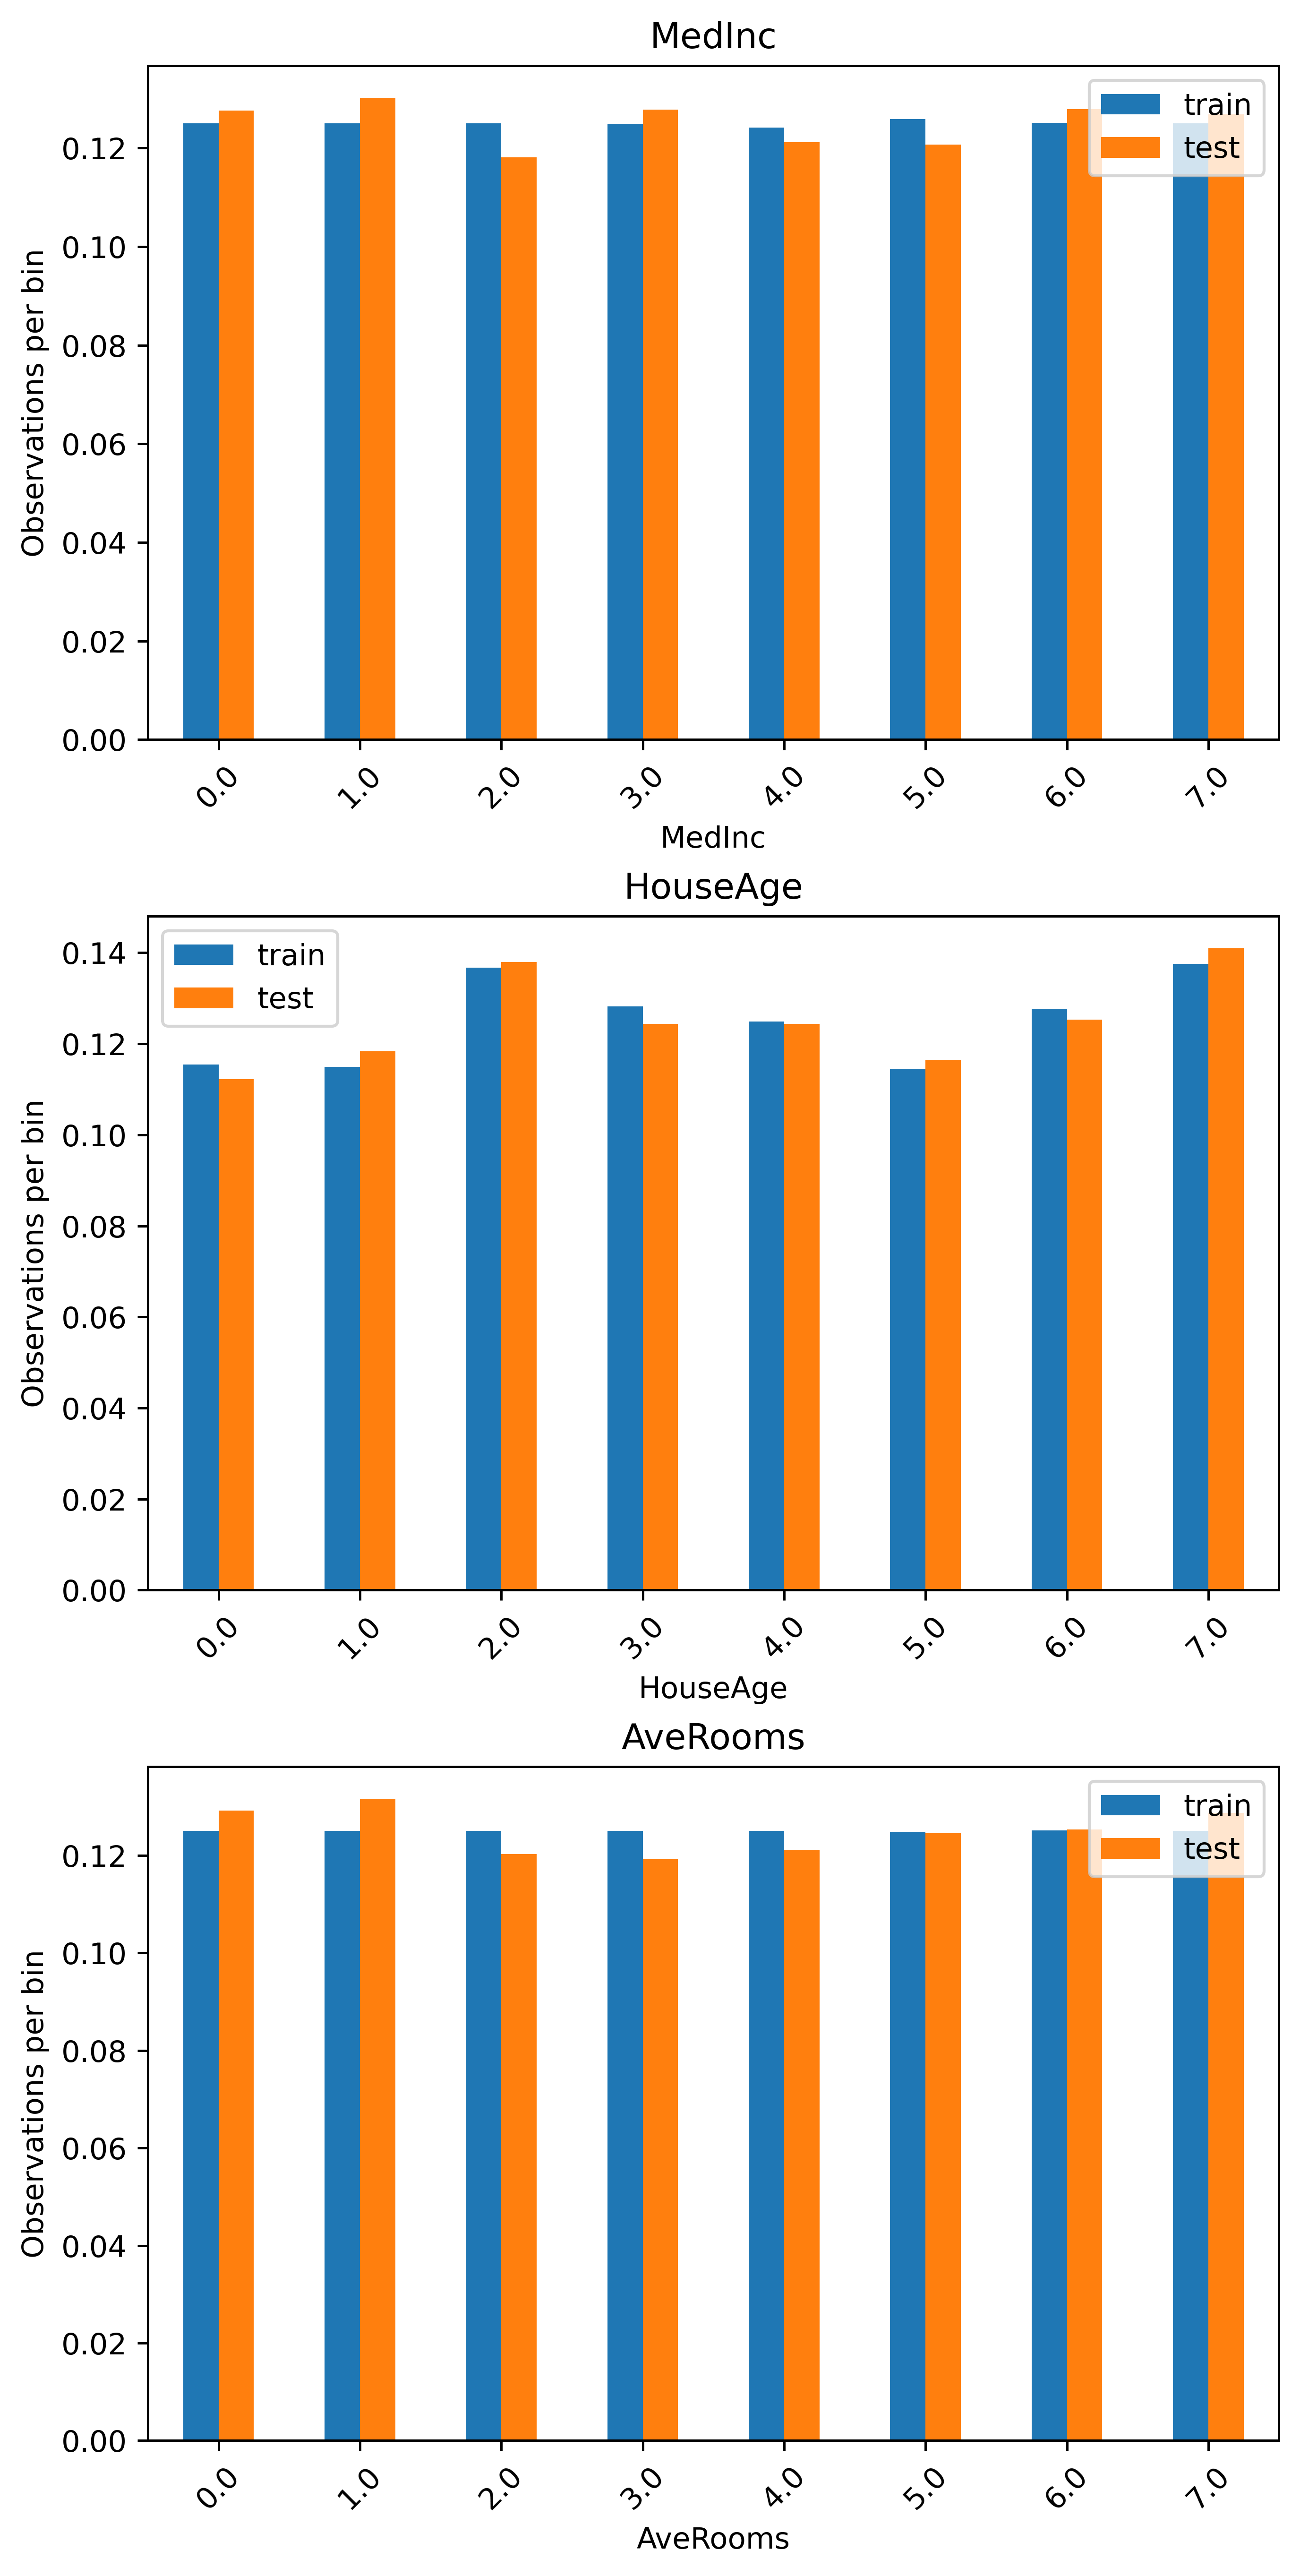

In [23]:
# Let's plot 3 variables:

plt.figure(figsize=(6, 12), constrained_layout=True)

for i in range(3):

    # location in figure
    ax = plt.subplot(3, 1, i + 1)

    # variable to plot
    var = variables[i]

    # determine proportion of observations per bin
    t1 = train_t[var].value_counts(normalize=True)
    t2 = test_t[var].value_counts(normalize=True)

    # concatenate proportions
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ["train", "test"]

    # order the intervals
    tmp.sort_index(inplace=True)

    tmp.plot.bar(ax=ax)
    plt.xticks(rotation=45)
    plt.ylabel("Observations per bin")

    # add variable name as title
    ax.set_title(var)

plt.show()